## Feature Extraction and Data Analysis

### Goal of the notebook: 
- In this notebook we will try to analyze the given data to identify which columns are useful to traint the model

- Firstly, let's see how many columns are there and what are they.

In [201]:
import numpy as np
import pandas as pd
import gzip
import json
import re

from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from pandas import json_normalize

# Load the compressed JSON file
df = pd.read_json('training-dataset.jsonl.gz', lines=True, compression='gzip')



In [202]:
df_profile = json_normalize(df['profile'])
df_posts = df['posts']

In [203]:
df_profile.head(0)


,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64


In [204]:
# List all the columns in the profile dataframe in a better format
print("Columns in the profile dataframe:")
for i, col in enumerate(df_profile.columns):
    print(f"{i+1}. {col}")

Columns in the profile dataframe:
1. username
2. id
3. full_name
4. biography
5. category_name
6. post_count
7. follower_count
8. following_count
9. is_business_account
10. is_private
11. is_verified
12. highlight_reel_count
13. bio_links
14. entities
15. ai_agent_type
16. fb_profile_biolink
17. restricted_by_viewer
18. country_block
19. eimu_id
20. external_url
21. fbid
22. has_clips
23. hide_like_and_view_counts
24. is_professional_account
25. is_supervision_enabled
26. is_guardian_of_viewer
27. is_supervised_by_viewer
28. is_supervised_user
29. is_embeds_disabled
30. is_joined_recently
31. business_address_json
32. business_contact_method
33. business_email
34. business_phone_number
35. business_category_name
36. overall_category_name
37. category_enum
38. is_verified_by_mv4b
39. is_regulated_c18
40. profile_pic_url
41. should_show_category
42. should_show_public_contacts
43. show_account_transparency_details
44. profile_picture_base64


We have 44 feature for each profile + 35 posts (each have 7 different features). So, let's try to get rid of some profile features. We know all ids are unique, so we cannot extract anything from them. Also all URL and json formatted columns are probably very hard to extract information, so we can just ignore them at least at this point.

I also just dropped a few metadata related features. In total, I eliminated 11 different features which are below.

In [205]:
# Drop useless features
# These are mostly metadata, and some links that are not useful for our analysis
# We also drop the id column, since it is unique for each user and does not provide any useful information

df_profile = df_profile.drop(columns=['id', 'bio_links','country_block'
                                      ,'eimu_id', 'external_url','fbid'
                                      ,'profile_pic_url','profile_picture_base64'
                                      ,'fb_profile_biolink'
                                      ,'show_account_transparency_details'
                                      , 'business_address_json'])

In [206]:
df_profile.shape

(5415, 33)

Great! We just eliminated 11 features, remained 33...
- At this point I want to measure the variance of each column. If the variance is very low, it indicates the data is not discriminative enough, so actually no need to keep them here.

- But, before doing that I need to eliminate the text based columns and encode the categorical columns

- Also, I will have to get rid of mostly null blocks.

In [207]:
# Calculate percentage of null values for each column
null_percentages = (df_profile.isnull().sum() / len(df_profile) * 100).round(2)

# Sort values in descending order and create a readable format
null_analysis = pd.DataFrame({
    'Null %': null_percentages,
    'Non-Null %': 100 - null_percentages
}).sort_values('Null %', ascending=False)

print("Percentage of null values in each column:")
for idx, row in null_analysis.iterrows():
    print(f"{idx:<30} : {row['Null %']:>6.2f}% null, {row['Non-Null %']:>6.2f}% non-null")

Percentage of null values in each column:
business_phone_number          : 100.00% null,   0.00% non-null
overall_category_name          : 100.00% null,   0.00% non-null
business_email                 : 100.00% null,   0.00% non-null
ai_agent_type                  : 100.00% null,   0.00% non-null
restricted_by_viewer           : 100.00% null,   0.00% non-null
business_category_name         :  89.97% null,  10.03% non-null
post_count                     :  89.31% null,  10.69% non-null
category_enum                  :  41.07% null,  58.93% non-null
category_name                  :  18.84% null,  81.16% non-null
biography                      :   6.43% null,  93.57% non-null
entities                       :   6.43% null,  93.57% non-null
full_name                      :   1.03% null,  98.97% non-null
is_joined_recently             :   0.00% null, 100.00% non-null
business_contact_method        :   0.00% null, 100.00% non-null
username                       :   0.00% null, 100.00% non-nul

- Interestingly we have 5 columns which are 100% NULL in our data. So, (with a great pleasure) we can drop them.

- I decided to set a treshold as if more than 25% of data missing. Just get rid of it.

In [208]:
df_profile = df_profile.drop(columns=[  'business_phone_number'
                                      , 'overall_category_name'
                                      , 'business_email'
                                      , 'ai_agent_type'
                                      , 'restricted_by_viewer'
                                      , 'business_category_name'
                                      , 'post_count'
                                      , 'category_enum'])

In [209]:
df_profile.shape

(5415, 25)

Now, we need to decide how we will fight against the missing data.

All the missing data is in the textual part. So, we can just replace them with empty string.
(Keep it simple...)

In [210]:
text_colums = ["category_name","biography", "username", "entities", "full_name"]

# Fill missing values with empty strings
df_profile[text_colums] = df_profile[text_colums].fillna('')

Now, there must be no null data.

In [211]:
# Calculate percentage of null values for each column
null_percentages = (df_profile.isnull().sum() / len(df_profile) * 100).round(2)

# Sort values in descending order and create a readable format
null_analysis = pd.DataFrame({
    'Null %': null_percentages,
    'Non-Null %': 100 - null_percentages
}).sort_values('Null %', ascending=False)

print("Percentage of null values in each column:")
for idx, row in null_analysis.iterrows():
    print(f"{idx:<30} : {row['Null %']:>6.2f}% null, {row['Non-Null %']:>6.2f}% non-null")

Percentage of null values in each column:
username                       :   0.00% null, 100.00% non-null
is_professional_account        :   0.00% null, 100.00% non-null
should_show_category           :   0.00% null, 100.00% non-null
is_regulated_c18               :   0.00% null, 100.00% non-null
is_verified_by_mv4b            :   0.00% null, 100.00% non-null
business_contact_method        :   0.00% null, 100.00% non-null
is_joined_recently             :   0.00% null, 100.00% non-null
is_embeds_disabled             :   0.00% null, 100.00% non-null
is_supervised_user             :   0.00% null, 100.00% non-null
is_supervised_by_viewer        :   0.00% null, 100.00% non-null
is_guardian_of_viewer          :   0.00% null, 100.00% non-null
is_supervision_enabled         :   0.00% null, 100.00% non-null
hide_like_and_view_counts      :   0.00% null, 100.00% non-null
full_name                      :   0.00% null, 100.00% non-null
has_clips                      :   0.00% null, 100.00% non-nul

In [212]:
# Create a new dataframe excluding text columns but including boolean columns
numeric_df = df_profile.select_dtypes(include=['int64', 'bool']).copy()

# Convert boolean columns to numeric (0/1)
bool_columns = numeric_df.select_dtypes(include=['bool']).columns
numeric_df[bool_columns] = numeric_df[bool_columns].astype(int)

# Calculate variance for each column
variances = numeric_df.var()

# Create a readable format for the results
variance_analysis = pd.DataFrame({
    'Variance': variances,
}).sort_values('Variance', ascending=False)
zero_variance_columns = []
print("Variance of numeric columns:")
for idx, row in variance_analysis.iterrows():
    print(f"{idx:<30} : {row['Variance']:,.9f}")
    if row['Variance'] < 1e-3:
        zero_variance_columns.append(idx)

Variance of numeric columns:
follower_count                 : 21,358,813,287,149.109375000
following_count                : 973,836.608447848
highlight_reel_count           : 18,094.788261069
is_business_account            : 0.207220226
is_verified                    : 0.183999692
should_show_public_contacts    : 0.154403088
should_show_category           : 0.146715008
has_clips                      : 0.067163378
hide_like_and_view_counts      : 0.060468721
is_professional_account        : 0.000553812
is_private                     : 0.000369276
is_regulated_c18               : 0.000184672
is_guardian_of_viewer          : 0.000000000
is_supervised_by_viewer        : 0.000000000
is_supervised_user             : 0.000000000
is_embeds_disabled             : 0.000000000
is_joined_recently             : 0.000000000
is_verified_by_mv4b            : 0.000000000
is_supervision_enabled         : 0.000000000


We will drop all columns with varince less than 1e-3. These columns doesn't change at all in our case. Nothing discriminative.

Actually, since we didn't normalize the numeric colunns, this analysis is a bit wrong. Anyway, I am doing this only to see wheter all the bool features are useful or some of them is just doesn't discriminative at all.

In [213]:
# Drop columns with zero variance from  df_profile
df_profile = df_profile.drop(columns=zero_variance_columns)

In [214]:
df_profile.shape

(5415, 15)

In [215]:
df_profile.head(0)

,username,full_name,biography,category_name,follower_count,following_count,is_business_account,is_verified,highlight_reel_count,entities,has_clips,hide_like_and_view_counts,business_contact_method,should_show_category,should_show_public_contacts


In [216]:
# Count UNKNOWN values and calculate percentage
unknown_count = (df_profile['business_contact_method'] == 'UNKNOWN').sum()
total_count = len(df_profile)
unknown_percentage = (unknown_count / total_count) * 100

print(f"Number of UNKNOWN values: {unknown_count}")
print(f"Percentage of UNKNOWN values: {unknown_percentage:.2f}%")

Number of UNKNOWN values: 2527
Percentage of UNKNOWN values: 46.67%


In [217]:
# Create dummy variables for business_contact_method
business_contact_encoded = pd.get_dummies(df_profile['business_contact_method'], prefix='contact')

# Get the distribution
contact_distribution = df_profile['business_contact_method'].value_counts()
contact_percentage = (contact_distribution / len(df_profile) * 100).round(2)

# Display distribution with counts and percentages
for method, count in contact_distribution.items():
    percentage = contact_percentage[method]
    print(f"{method:<10}: {count:>5} ({percentage:>6.2f}%)")


CALL      :  2778 ( 51.30%)
UNKNOWN   :  2527 ( 46.67%)
TEXT      :   110 (  2.03%)


In [218]:
df_profile = df_profile.drop(columns=['business_contact_method'])

Now, let's see the correleation between the columns

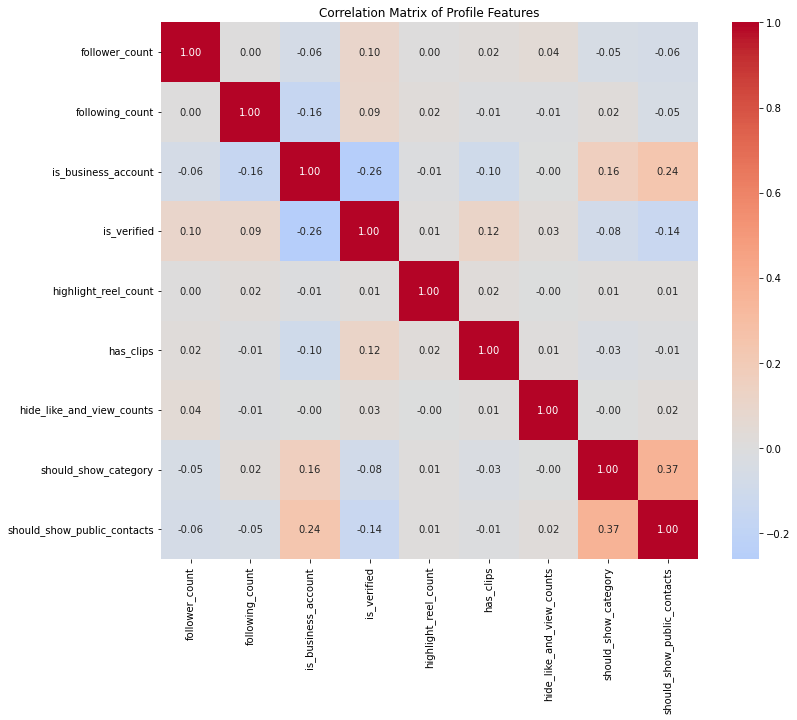

In [219]:
import seaborn as sns

import matplotlib.pyplot as plt

# Select numeric columns for correlation
numeric_cols = df_profile.select_dtypes(include=['int64', 'bool']).copy()

# Convert boolean columns to int
numeric_cols = numeric_cols.astype(int)

# Calculate correlation matrix
correlation_matrix = numeric_cols.corr()

# Create a figure with appropriate size
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.2f',  # Format correlation values to 2 decimal places
            square=True)  # Make the plot square-shaped

plt.title('Correlation Matrix of Profile Features')
plt.tight_layout()
plt.show()

It seems like highlighted_reel_count and has_clips has no negative or positive correlation with anything. They are most likely to be independent. However, to assure ourselfe we will include the labels into the picture and measure the mutual information wrt labels of each column

In [220]:
# Load the training classification data
training_data = pd.read_csv('train-classification.csv')
training_data.head()
# Rename the column Unnamed: 0 to username
training_data = training_data.rename(columns={'Unnamed: 0': 'username'})
training_data.head()
# Merge the df_profile and training_data dataframes
merged_df = pd.merge(df_profile, training_data, on='username')

merged_df.head()




,username,full_name,biography,category_name,follower_count,following_count,is_business_account,is_verified,highlight_reel_count,entities,has_clips,hide_like_and_view_counts,should_show_category,should_show_public_contacts,label
0,deparmedya,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,1167,192,True,False,6,#mediaplanning #mediabuying #sosyalmedya,True,False,True,True,Tech
1,kafesfirin,KAFES FIRIN,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,Brand,11997,17,True,False,15,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,True,False,True,True,Food
2,vimerang,Vimerang,Dijital İletişim Yönetimi🎬info@vimerang.comq,,2321,454,True,False,11,Dijital İletişim Yönetimi🎬info@vimerang.comq,True,True,True,True,Tech
3,mustafa_yalcinn38,Mustafa Yalçın,Talas Belediye Başkanı,Politician,13647,29,True,True,2,Talas Belediye Başkanı,True,False,True,False,Health and Lifestyle
4,zorluenergysolutions,ZES (Zorlu Energy Solutions),Türkiye’nin 81 ilindeki en yaygın elektrikli ş...,,7917,11,True,True,7,Türkiye’nin 81 ilindeki en yaygın elektrikli ş...,True,False,True,True,Tech


In [221]:
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import LabelEncoder

label_encoders = {}

# Encode 'category_name'
label_encoders['category_name'] = LabelEncoder()
merged_df['category_name'] = label_encoders['category_name'].fit_transform(merged_df['category_name'])

# Encode 'label'
label_encoders['label'] = LabelEncoder()
merged_df['label'] = label_encoders['label'].fit_transform(merged_df['label'])




In [222]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

# Replace NaNs if needed and drop non-numeric columns
merged_df = merged_df.fillna(0)  # Replace missing values
merged_df = merged_df.drop(columns=text_colums)  # Drop text columns if present

# Define the target column
target_column = 'label'
feature_columns = [col for col in merged_df.columns if col != target_column]

# Calculate mutual information between features and the target column
mutual_info_values = mutual_info_regression(merged_df[feature_columns], merged_df[target_column])

# Create a DataFrame for better readability
mutual_info_df = pd.DataFrame({
    'Feature': feature_columns,
    'Mutual Information': mutual_info_values
}).sort_values(by='Mutual Information', ascending=False)

# Display the mutual information values
print(mutual_info_df)


                       Feature  Mutual Information
0               follower_count            0.076323
1              following_count            0.058265
3                  is_verified            0.036417
4         highlight_reel_count            0.028805
2          is_business_account            0.028053
8  should_show_public_contacts            0.026341
7         should_show_category            0.021793
5                    has_clips            0.000000
6    hide_like_and_view_counts            0.000000


In [223]:
df_profile = df_profile.drop(columns=['should_show_category', 'has_clips', 'hide_like_and_view_counts', 'should_show_public_contacts'])

In [224]:
df_profile.head()

,username,full_name,biography,category_name,follower_count,following_count,is_business_account,is_verified,highlight_reel_count,entities
0,deparmedya,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,1167,192,True,False,6,#mediaplanning #mediabuying #sosyalmedya
1,beyazyakaliyiz,Selam Beyaz Yakalı,Beyaz yakalıların dünyasına hoşgeldiniz 😀😀😀,Personal blog,1265,665,True,False,0,Beyaz yakalıların dünyasına hoşgeldiniz 😀😀😀
2,kafesfirin,KAFES FIRIN,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,Brand,11997,17,True,False,15,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...
3,vimerang,Vimerang,Dijital İletişim Yönetimi🎬info@vimerang.comq,,2321,454,True,False,11,Dijital İletişim Yönetimi🎬info@vimerang.comq
4,totalenergies_istasyonlari,TotalEnergies İstasyonları,TotalEnergies İstasyonları resmi Instagram hes...,Energy Company,28025,4,True,False,10,TotalEnergies İstasyonları resmi Instagram hes...


### Conclusion: 

- We have the remaining 10 features, now we need to do feature extraction from text based columns.

- We will most likely drop the username since it is also unique, but will keep the full name and merge it with the biography

- Since the category name varies too much, I believe it is also meaningful to merge these things into biography.

- The entities column also will be merged into the biography, then we will implement some vectorization to this new biography. (TF-IDF etc.)

- If we do all these merges at the end we will have 6 features and I think this is the best of what we can use according to analysis till now.

In [2]:
dropped_columns = [
    # From cell 8
    'id', 'bio_links', 'country_block', 'eimu_id', 'external_url', 'fbid',
    'profile_pic_url', 'profile_picture_base64', 'fb_profile_biolink',
    'show_account_transparency_details', 'business_address_json',
    
    # From cell 13
    'business_phone_number', 'overall_category_name', 'business_email',
    'ai_agent_type', 'restricted_by_viewer', 'business_category_name',
    'post_count', 'category_enum',
    
    # From cell 19 (zero_variance_columns)
    'is_professional_account', 'is_private', 'is_regulated_c18',
    'is_guardian_of_viewer', 'is_supervised_by_viewer', 'is_supervised_user',
    'is_embeds_disabled', 'is_joined_recently', 'is_verified_by_mv4b',
    'is_supervision_enabled',
    
    # From cell 26
    'business_contact_method',
    
    # From cell 33
    'should_show_category', 'has_clips', 'hide_like_and_view_counts',
    'should_show_public_contacts'
]

In [3]:
len(dropped_columns)

34